## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [53]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from src.data.make_dataset import TCGA_LUAD
tgca_luad = TCGA_LUAD()

mirna_tumor (506, 1883)
mirna_normal (46, 1883)
gene_tumor (515, 20486)
gene_normal (59, 20486)


## Univariate feature selection via FDR

In [150]:
from sklearn.feature_selection import SelectFdr, f_classif

# Select the p-values for an estimated false discovery rate
# FDR 
# mirna_filter = SelectFdr(f_classif, alpha=0.01)
# mirna_new = mirna_filter.fit_transform(X=pandas.concat([mirna_tumor, mirna_normal]), y=Y)

gene_exp_filter = SelectFdr(f_classif, alpha=0.01)
gen_exp_new = gene_exp_filter.fit_transform(X=pandas.concat([gene_exp_tumor, gene_exp_normal]), y=Y)

print mirna_new.shape
print gen_exp_new.shape
# mirna_tumor = mirna_tumor[mirna_tumor.columns[mirna_filter.get_support(indices=True)]]
# mirna_normal = mirna_normal[mirna_normal.columns[mirna_filter.get_support(indices=True)]]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor.columns[gene_exp_filter.get_support(indices=True)]]
gene_exp_normal = gene_exp_normal[gene_exp_normal.columns[gene_exp_filter.get_support(indices=True)]]

ValueError: could not convert string to float: TCGA-91-6849

## Loading TargetScan database for predicted miRNA-targets interactions

In [54]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(tgca_luad.mirna_list) & targetScan_df['Gene Symbol'].isin(tgca_luad.gene_symbols)]
print targetScan_df.shape

(185330, 2)


## Build miRNA-target relationship network to from putative predicted miRNA-target pairs
## Assign miRNA's to groups from the miRNA-target bipartite graph obtained above
The assumption used is that two miRNA's are in the same group, if they share the same target
If a miRNA has overlapping groups, "larger_groups_first" param decides whether larger or smaller group takes priority

In [242]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import networkx as nx

network = miRNATargetNet(miRNAs=tgca_luad.mirna_list, targets=tgca_luad.gene_symbols, dys_threshold=0.4)

print network.fit(tag="normal-StgI",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='normal',
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='normal',
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=targetScan_df)

n_A 20
n_B 275


src/models/miRNA_target_network.py:52: RuntimeWarning: invalid value encountered in double_scalars
  


src/models/miRNA_target_network.py:56: RuntimeWarning: invalid value encountered in double_scalars
  


27762


In [244]:
network.fit(tag="StgI-StgII",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=targetScan_df)

n_A 275
n_B 120


973

In [249]:
network.fit(tag="StgII-StgIII",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=targetScan_df)

n_A 120
n_B 84


2665

In [1]:
network.fit(tag="StgIII-StgIV",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage IV'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage IV'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=targetScan_df)

NameError: name 'network' is not defined

In [251]:
import networkx

tags = ['normal-StgI', 'StgI-StgII', 'StgII-StgIII', 'StgIII-StgIV']

normal_stgI_genes = np.unique([tup[1] for tup in network.B.edges(data=True) if tup[2]['tag'] == 'normal-StgI']).tolist()
stgI_StgII_genes = np.unique([tup[1] for tup in network.B.edges(data=True) if tup[2]['tag'] == 'StgI-StgII']).tolist()
stgII_StgIII_genes = np.unique([tup[1] for tup in network.B.edges(data=True) if tup[2]['tag'] == 'StgII-StgIII']).tolist()
stgIII_StgIV_genes = np.unique([tup[1] for tup in network.B.edges(data=True) if tup[2]['tag'] == 'StgIII-StgIV']).tolist()
miRNAs_in_MTDN = np.unique([tup[0] for tup in network.B.edges()])

print 'normal_stgI_genes', len(normal_stgI_genes)
print 'stgI_StgII_genes', len(stgI_StgII_genes)
print 'stgII_StgIII_genes', len(stgII_StgIII_genes)
print 'stgIII_StgIV_genes', len(stgIII_StgIV_genes)
print 'miRNAs_in_MTDN', len(miRNAs_in_MTDN)

normal_stgI_genes_names = [gene+'/normal-StgI' for gene in normal_stgI_genes]
stgI_StgII_genes_names = [gene+'/StgI-StgII' for gene in stgI_StgII_genes]
stgII_StgIII_genes = [gene+'/StgII-StgIII' for gene in stgII_StgIII_genes]
stgIII_StgIV_genes = [gene+'/StgIII-StgIV' for gene in stgIII_StgIV_genes]

miRNA_target_assn_matrix = pandas.DataFrame(columns=normal_stgI_genes_names +
                                                    stgI_StgII_genes_names +
                                                    stgII_StgIII_genes +
                                                    stgIII_StgIV_genes)

for miRNA in miRNAs_in_MTDN:
    miRNA_target_assn_matrix.loc[miRNA] = 0

for edge in network.B.edges(data=True):
    miRNA_target_assn_matrix.loc[edge[0]][edge[1]+'/'+edge[2]['tag']] = 1
      
      
print 'shape', miRNA_target_assn_matrix.shape
print "sum assn matrix", miRNA_target_assn_matrix.sum(axis=0).sum()
print "all edges", len(network.B.edges())
# [i for i in networkx.common_neighbors(network.B, 'hsa-mir-29c', 'hsa-mir-29a')]

normal_stgI_genes 6763
stgI_StgII_genes 337
stgII_StgIII_genes 1239
stgIII_StgIV_genes 6567
miRNAs_in_MTDN 276


shape (276, 14906)
sum assn matrix 46445.0
all edges 46445


In [254]:
from sklearn.cluster import AgglomerativeClustering

mirna_cluster = AgglomerativeClustering(n_clusters=20, affinity='l1', linkage='complete').fit(miRNA_target_assn_matrix)
print np.bincount(mirna_cluster.fit_predict(miRNA_target_assn_matrix))

[225  11   4   3   5   1   2   2   4   1   6   1   1   1   1   1   1   1
   4   1]


### Prepare samples for Classification task

In [286]:
X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=True, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
                              label_mapping={'normal': -1, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1})

X_multi, y_multi = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
                                          label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4})

print "X", X.shape
print "y", y.shape

print y.value_counts()
print y_multi.value_counts()

X (92, 1881)
y (92,)
 1    46
-1    46
Name: pathologic_stage, dtype: int64
1    277
2    121
3     84
0     46
4     24
Name: pathologic_stage, dtype: int64


## Create Classifiers

In [288]:
from sklearn.model_selection import train_test_split
from src.models.group_lasso_spams import SPAMSClassifier
import spams

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'it0': 10, 'max_it': 1000,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}
param['lambda1'] = 0.5
param['lambda2'] = 0.5
param['lambda3'] = 0.5

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = \
    train_test_split(X_multi, y_multi, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y_multi)

X_train = np.asfortranarray(X_train, dtype=myfloat)
Y_train = np.asfortranarray(Y_train, dtype=myfloat)
Y_train = np.reshape(Y_train, [Y_train.shape[0], 1])
X_multi_train = np.asfortranarray(X_multi_train, dtype=myfloat)
Y_multi_train = np.asfortranarray(Y_multi_train, dtype=myfloat)
Y_multi_train = np.reshape(Y_multi_train, [Y_multi_train.shape[0], 1])

# Group Lasso L2
group_l2_param = param.copy()
group_l2_param['loss'] = 'weighted-logistic'
group_l2_param['regul'] = 'group-lasso-l2'
group_l2 = SPAMSClassifier()
group_l2.fit(X_train, Y_train, groups=network.get_miRNA_cluster_assgn(), params=group_l2_param)

# L1 Lasso
l1_lasso_param = param.copy()
l1_lasso_param['loss'] = 'weighted-logistic'
l1_lasso_param['regul'] = 'l1'
l1_lasso = SPAMSClassifier()
l1_lasso.fit(X_train, Y_train, groups=None, params=l1_lasso_param)

# Elastic Net
elastic_net_param = param.copy()
elastic_net_param['loss'] = 'weighted-logistic'
elastic_net_param['regul'] = 'elastic-net'
elastic_net = SPAMSClassifier()
elastic_net.fit(X_train, Y_train, groups=None, params=elastic_net_param)

# Sparse Group Lasso
sparse_group_l2_param = param.copy()
sparse_group_l2_param['loss'] = 'weighted-logistic'
sparse_group_l2_param['regul'] = 'sparse-group-lasso-l2'
sparse_group_l2_param['lambda1'] = 0.2
sparse_group_l2 = SPAMSClassifier()
sparse_group_l2.fit(X_train, Y_train, groups=network.get_miRNA_cluster_assgn(), params=sparse_group_l2_param)

# Multi Logistic
multi_group_l2_param = param.copy()
multi_group_l2_param['loss'] = 'multi-logistic'
multi_group_l2_param['regul'] = 'l1l2'
multi_group_l2 = SPAMSClassifier()
multi_group_l2.fit(X_multi_train, Y_multi_train, groups=network.get_miRNA_cluster_assgn(), params=multi_group_l2_param)

## Logistic Regression with L1L2 & Overlapping Group LASSO regularizer

In [43]:
import parsimony.estimators as estimators
import parsimony.algorithms as algorithms
import parsimony.functions.nesterov.gl as gl
import parsimony.utils.start_vectors as start_vectors
# 
# X_train, X_test, Y_train, Y_test = \
#     train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

A = gl.linear_operator_from_groups(X_train.shape[1],
                                   network.miRNA_groups_int
                                   # weights=[2*1./len(g) for g in network.miRNA_groups_int]
                                   )
beta = start_vectors.ZerosStartVector().get_vector(X_train.shape[1])

logistic_L1L2GL = estimators.LogisticRegressionL1L2GL(l1=3., l2=0.0, gl=3., A=A,
                                                      algorithm=algorithms.proximal.FISTA(),
                                                      class_weight='auto',
                                                      algorithm_params=dict(max_iter=1000),
                                                      mean=False)
logistic_L1L2GL.fit(X=X_train, y=Y_train, beta=beta)

print 'Non-zero:', len(logistic_L1L2GL.beta.nonzero()[0])

Non-zero: 244


In [38]:
# [(label, percent[0]) for label, percent in zip(logistic_L1L2GL.predict(X_test), logistic_L1L2GL.predict_probability(X_test))]


## Classification Report

In [44]:
from sklearn import metrics

for model, name in [(logistic_L1L2GL, 'Logistic L1L2GL'),
                    (multi_group_l2, 'multi-task group_small'),
                    (group_l2, 'group_small'),
                    (group_l2_large_groups, 'group_large'),
                    (l1_lasso, 'l1_lasso'),
                    (elastic_net, 'elastic_net'),
                    (sparse_group_l2, 'sparse-group_small'),
                    (sparse_group_l2_large_groups, 'sparse_group_large')]:
    print '\n', name
    if name is 'Logistic L1L2GL':
        predicted = logistic_L1L2GL.predict(X_train)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_train, predicted)
        predicted = logistic_L1L2GL.predict(X_test)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_test, predicted)
    elif name is 'multi-task group_small':
        print metrics.classification_report(Y_multi_train, model.predict(X_multi_train))
        print metrics.classification_report(Y_multi_test, model.predict(X_multi_test))
    else:
        print metrics.classification_report(Y_train, model.predict(X_train))
        print metrics.classification_report(Y_test, model.predict(X_test))


Logistic L1L2GL
             precision    recall  f1-score   support

       -1.0       1.00      1.00      1.00        36
        1.0       1.00      1.00      1.00        37

avg / total       1.00      1.00      1.00        73

             precision    recall  f1-score   support

         -1       1.00      1.00      1.00        10
          1       1.00      1.00      1.00         9

avg / total       1.00      1.00      1.00        19


multi-task group_small
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00        37
        1.0       0.63      0.93      0.75       221
        2.0       0.65      0.29      0.40        97
        3.0       0.68      0.31      0.43        67
        4.0       0.75      0.16      0.26        19

avg / total       0.68      0.67      0.62       441

             precision    recall  f1-score   support

          0       0.89      0.89      0.89         9
          1       0.55      0.82      0.66      

## Loading HMDD database for experimentally validated NSCLC miRNA

In [40]:
HMDD_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/HMDD_miRNA-disease.txt'), delimiter='\t', header=-1)
HMDD_df = HMDD_df[HMDD_df[2] == "Lung Neoplasms"]
HMDD_lung_neoplasm_miRNAs = HMDD_df[1].unique()
print "HMDD_lung_neoplasm_miRNAs", HMDD_lung_neoplasm_miRNAs.shape

miRCancer_luad_miRNA_df = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))
miRCancer_luad_miRNAs = set(miRCancer_luad_miRNA_df['miRNA'].tolist())
print "miRCancer_luad_miRNAs", len(miRCancer_luad_miRNAs)


mir2disease_nsclc_miRNA_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/mir2Disease_miRNA-Disease.txt'), delimiter='\t', header=-1) 
mir2disease_nsclc_miRNA_df.columns = ['miRNA', 'disease', 'up_down', 'method', 'year', 'description'] 
mir2disease_nsclc_miRNA_df = mir2disease_nsclc_miRNA_df[(mir2disease_nsclc_miRNA_df['disease'] == 'non-small cell lung cancer (NSCLC)')]
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.lower()
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("*", "")
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("-3p.*|-5p.*", "")
mir2disease_nsclc_miRNA_df.drop_duplicates(inplace=True)
mir2disease_nsclc_miRNAs = mir2disease_nsclc_miRNA_df['miRNA'].unique()
print "mir2disease_nsclc_miRNAs", mir2disease_nsclc_miRNAs.shape

validating_miRNAs = HMDD_lung_neoplasm_miRNAs

HMDD_lung_neoplasm_miRNAs (157,)
miRCancer_luad_miRNAs 27
mir2disease_nsclc_miRNAs (24,)


## Compare models by recall rate

In [230]:
from src.utils.validate_candidate_miRNAs import recall_rate, precision_rate, get_miRNA_names

models = []
for model, name in [(logistic_L1L2GL, 'Logistic L1L2GL'),
                    (multi_group_l2, 'multi-task group_small'),
                    (group_l2, 'group_small'),
                    (group_l2_large_groups, 'group_large'),
                    (l1_lasso, 'l1_lasso'),
                    (elastic_net, 'elastic_net'),
                    (sparse_group_l2, 'sparse-group_small'),
                    (sparse_group_l2_large_groups, 'sparse_group_large')]:
    if name is 'Logistic L1L2GL':
        models.append([name,
                   len(model.beta.nonzero()[0]),
                   recall_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:], mirna_list),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:], mirna_list),
                                  validated_miRNAs=validating_miRNAs) ])
    else:
        models.append([name,
                   model.get_selected_miRNAs(mirna_list)['miRNA'].shape[0],
                   recall_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(),
                                  validated_miRNAs=validating_miRNAs) ])

pandas.DataFrame(models, columns=['method', 'no_selected', 'recall_rate', 'precision_rate']).sort_values(by='recall_rate', ascending=False)
# (group_l2_large_groups, 'group_l2_large_groups'),
# (l1_lasso, 'l1_lasso'),
# (elastic_net, 'elastic_net'),
# (sparse_group_l2, 'sparse-group-lasso-l2'),
# (sparse_group_l2_large_groups, 'sparse_group_l2_large_groups')

,method,no_selected,recall_rate,precision_rate
1,multi-task group_small,264,0.588235,0.568182
3,group_large,194,0.545098,0.716495
0,Logistic L1L2GL,244,0.541176,0.565574
2,group_small,161,0.415686,0.658385
4,l1_lasso,149,0.368627,0.630872
5,elastic_net,149,0.368627,0.630872
7,sparse_group_large,137,0.356863,0.664234
6,sparse-group_small,135,0.349020,0.659259


## Check each candidate miRNA's if validated

In [180]:
candidate_miRNAs = sparse_group_l2.get_selected_miRNAs(mirna_list)
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in HMDD_lung_neoplasm_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.head(20)

,miRNA,coef,validated,groups
67,hsa-mir-22,0.000199,True,"[6, 165, 245, 312, 347, 362, 363, 427, 775, 95..."
37,hsa-mir-148a,0.000191,True,"[81, 317, 343, 429, 547, 852, 1019, 1107, 1234..."
47,hsa-mir-182,0.000162,True,"[78, 132, 164, 326, 363, 390, 423, 492, 516, 5..."
85,hsa-mir-30a,-0.000150,True,"[35, 134, 153, 205, 297, 331, 349, 400, 401, 4..."
61,hsa-mir-203a,0.000117,False,"[189, 405, 413, 486, 540, 598, 697, 956, 986, ..."
2,hsa-let-7a-3,-0.000098,True,[]
0,hsa-let-7a-1,-0.000098,True,[]
84,hsa-mir-29c,0.000094,True,"[18, 27, 59, 216, 218, 282, 314, 416, 467, 519..."
81,hsa-mir-29a,0.000093,True,"[59, 96, 216, 218, 260, 282, 290, 304, 393, 41..."
8,hsa-let-7f-2,-0.000087,True,[]


In [171]:
candidate_miRNAs = pandas.DataFrame([(mirna_list[m], logistic_L1L2GL.beta[m][0]) for m in logistic_L1L2GL.beta.nonzero()[0]])
candidate_miRNAs.columns = ['miRNA', 'coef']
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in HMDD_lung_neoplasm_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.reindex(candidate_miRNAs.coef.abs().sort(inplace=False, ascending=False).index).head(20)

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


,miRNA,coef,validated,groups
74,hsa-mir-148a,0.000232,True,"[81, 317, 343, 429, 547, 852, 1019, 1107, 1234..."
95,hsa-mir-182,0.000193,True,"[78, 132, 164, 326, 363, 390, 423, 492, 516, 5..."
145,hsa-mir-22,0.000162,True,"[6, 165, 245, 312, 347, 362, 363, 427, 775, 95..."
171,hsa-mir-30a,-0.000123,True,"[35, 134, 153, 205, 297, 331, 349, 400, 401, 4..."
21,hsa-mir-10a,0.000096,False,"[63, 771, 926, 929, 1131, 1498, 1519, 1553, 15..."
0,hsa-let-7a-1,-0.000085,True,[]
2,hsa-let-7a-3,-0.000085,True,[]
8,hsa-let-7f-2,-0.000081,True,[]
7,hsa-let-7f-1,-0.000080,True,[]
127,hsa-mir-203a,0.000079,False,"[189, 405, 413, 486, 540, 598, 697, 956, 986, ..."


## Validate miRNA-target edges

In [54]:
validated_edges = pandas.DataFrame()
for (v1, v2) in edges:
    print v1, v2
    if network.B.node[v1]['bipartite'] == 0:  # if v1 is miRNA
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v1) &
                                                      (miRecords_df["Target gene_name"] == v2)]])
    else:
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v2) &
                                                      (miRecords_df["Target gene_name"] == v1)]])

print float(len(validated_edges))/float(len(edges))

ITGA4 hsa-mir-301b


NameError: name 'miRecords_df' is not defined

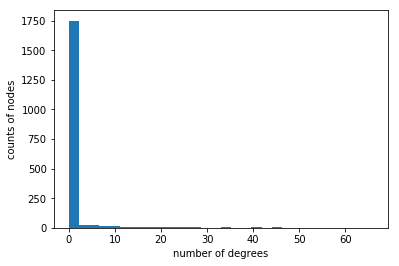

In [ ]:
# plt.hist(miRNAs_nodes_degrees[1].values())
plt.hist(targets_nodes_degrees[0].values(), bins=30)
plt.ylabel('counts of nodes')
plt.xlabel('number of degrees')
plt.show()